In [1]:
from IPython.display import Image

from segar.mdps import MDP
from segar.sim import Simulator
from segar.tasks.classic_control import SimpleMountainCarInitialization, MountainCarTask, MountainCarObservation, from_mountaincar_basis
from segar.tools.sample_trajectories import rollout, save_gif

/Users/rdevonhjelm/Code/segar/segar/factors/shapes.py:26: DeprecationWarning: Please use `ConvexHull` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, Delaunay
/Users/rdevonhjelm/Code/segar/segar/factors/shapes.py:26: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, Delaunay


/Users/rdevonhjelm/miniconda3-x86/envs/segar/lib/python3.9/site-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


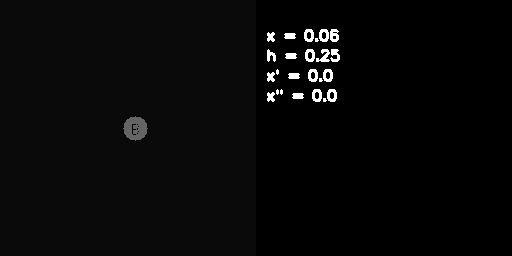

In [2]:
import numpy as np
sim = Simulator(friction=0., max_velocity=from_mountaincar_basis(0.7, recenter=False), gravity=0.0025, framerate=1)

initialization = SimpleMountainCarInitialization()
mountaincar_task = MountainCarTask(initialization)
observations = MountainCarObservation()
mdp = MDP(observations, mountaincar_task, max_steps_per_episode=200)
imgs, trajectories = rollout(mdp, show_render=True)

save_gif(imgs, out_path='mountaincar.gif')
Image(open('mountaincar.gif','rb').read())

In [4]:
import math
from gym.envs.classic_control import MountainCarEnv
import numpy as np

from segar.factors import Position, Velocity
from segar.tasks.classic_control import Angle, AngularVelocity, from_mountaincar_basis, to_mountaincar_basis

sim = Simulator(friction=0., max_velocity=from_mountaincar_basis(0.7, recenter=False), gravity=0.0025, framerate=1)

initialization = SimpleMountainCarInitialization()
mountaincar_task = MountainCarTask(initialization)
observations = MountainCarObservation()
mdp = MDP(observations, mountaincar_task, max_steps_per_episode=200)
mountaincar = sim.things['mountaincar']

env = MountainCarEnv()
env.kinematics_integrator = None
state = env.reset()
with mountaincar.in_place():
    mountaincar[Position] = np.array([from_mountaincar_basis(state[0]), 0.])
    mountaincar[Velocity] = np.array([from_mountaincar_basis(state[1], recenter=False), 0.])
assert np.allclose(mdp.observation(mdp.state), state), (mdp.observation(mdp.state), state)

for i in range(10):
    action = 0
    position = state[0]
    obs_mdp = mdp.step(action)[0]
    state = env.step(action)[0]
    assert np.allclose(obs_mdp, state)

/Users/rdevonhjelm/Code/segar/segar/rules/collisions.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = max(d, dist_left / abs(u[0]))


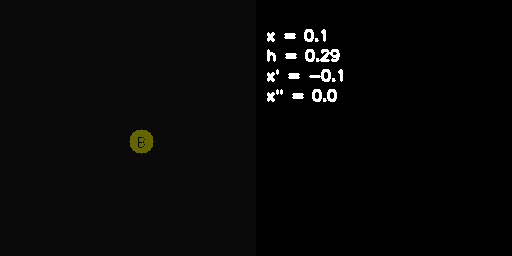

In [6]:
from segar.tasks.classic_control import CustomMountainCarInitialization
sim = Simulator(friction=0., max_velocity=from_mountaincar_basis(0.7, recenter=False), gravity=0.0025, framerate=1)

initialization = CustomMountainCarInitialization()
mountaincar_task = MountainCarTask(initialization)
observations = MountainCarObservation()
mdp = MDP(observations, mountaincar_task, max_steps_per_episode=200)
imgs, trajectories = rollout(mdp, show_render=True)

save_gif(imgs, out_path='mountaincar.gif')
Image(open('mountaincar.gif','rb').read())

In [7]:
initialization_a = CustomMountainCarInitialization(config_id='a')
initialization_b = CustomMountainCarInitialization(config_id='b')
initialization_c = CustomMountainCarInitialization(config_id='c')

In [9]:
from copy import deepcopy
from segar.mdps.metrics import task_set_init_dist

inits_a = []
inits_b = []
inits_c = []

for _ in range(100):
    initialization_a.sample()
    initialization_b.sample()
    initialization_c.sample()
    inits_a.append(deepcopy(initialization_a))
    inits_b.append(deepcopy(initialization_b))
    inits_c.append(deepcopy(initialization_c))

print(task_set_init_dist(inits_a, inits_b), task_set_init_dist(inits_a, inits_c), task_set_init_dist(inits_c, inits_b))

0.03961167857058627 0.04888835354363623 0.06371094711811025
